In [1]:
%matplotlib inline
import os 
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
from rasterio import features
from affine import Affine
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.lines import Line2D
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
from scipy.stats import t, norm, ttest_1samp, gaussian_kde
import xesmf as xe
from time import time
import warnings
from random import choices
from sklearn.neighbors import KernelDensity
warnings.filterwarnings('ignore')

In [2]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xarray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))


In [3]:
root_dir = "/dartfs-hpc/rc/lab/C/CMIG"
data_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "data")
fig_dir = os.path.join(root_dir, "agottlieb", "snow_drought", "figures")

In [4]:
grdc_basins = gpd.read_file(os.path.join(data_dir, "etc", "grdc_basins"), layer="mrb_basins")
basin_ids = {k: i for i, k in enumerate(grdc_basins.RIVER_BASI)}
basin_shapes = [(shape, n) for n, shape in enumerate(grdc_basins.geometry)]

In [5]:
# load basin-scale ensemble w/ peak and April 1 SWE
basin_swe_ensemble = pd.read_csv(os.path.join(data_dir,"ensembles","basin_peak_ensemble.csv"))
basin_swe_ensemble["time"] = pd.to_datetime(basin_swe_ensemble["time"].values)
basin_swe_ensemble = xr.Dataset.from_dataframe(basin_swe_ensemble.set_index(["product","time","basin"]))
basin_swe_ensemble = basin_swe_ensemble.sel(time=slice("2002-10-01", "2017-10-01"))

# calculate anomalies
basin_swe_ensemble["peak_swe_anom"] = (basin_swe_ensemble["peak_swe"]-basin_swe_ensemble["peak_swe"].mean("time")) / basin_swe_ensemble["peak_swe"].std("time")
basin_swe_ensemble["apr1_swe_anom"] = (basin_swe_ensemble["apr1_swe"]-basin_swe_ensemble["apr1_swe"].mean("time")) / basin_swe_ensemble["apr1_swe"].std("time")
basin_swe_ensemble["peak_date_anom"] = (basin_swe_ensemble["peak_date"]-basin_swe_ensemble["peak_date"].mean("time")) / basin_swe_ensemble["peak_date"].std("time")

# load basin-scale ensemble w/ SWEI
basin_swei_ensemble = pd.read_csv(os.path.join(data_dir,"ensembles","basin_swei_ensemble.csv"))
basin_swei_ensemble["time"] = pd.to_datetime(basin_swei_ensemble["time"].values)
basin_swei_ensemble = xr.Dataset.from_dataframe(basin_swei_ensemble.set_index(["product","time","basin"]))

# take min MAM SWEI and cumulative MAM SWE deficit and add to first ensemble
basin_swei_ensemble = basin_swei_ensemble.where((basin_swei_ensemble["time.month"]>=3)&(basin_swei_ensemble["time.month"]<=5))
basin_swe_ensemble["swei"] = basin_swei_ensemble["swei"].resample(time="AS-OCT").min().sel(time=slice("2002-10-01","2017-10-01"))
basin_swe_ensemble["swe_deficit"] = basin_swei_ensemble["SNOMAS_diff_clim"].resample(time="AS-OCT").sum(min_count=1).sel(time=slice("2002-10-01","2017-10-01"))

basin_swei_ensemble.close()

In [6]:
# rasterize basins onto 0.5 degree grid, merge with SWE ensemble
res = 0.5
coords = {"lat": np.arange(-90+res/2, 90+res/2, res)[::-1],
          "lon": np.arange(-180+res/2, 180+res/2, res)}
basin_grid = rasterize(basin_shapes, coords=coords)
basin_grid.name="basin"
basin_grid_df = basin_grid.to_dataframe().reset_index()
basin_grid_df.dropna(subset=["basin"],inplace=True)
basin_swe_ensemble_df = basin_swe_ensemble.to_dataframe().reset_index()
basin_swe_ensemble_df = basin_swe_ensemble_df.merge(basin_grid_df,on="basin")
basin_swe_ensemble = xr.Dataset.from_dataframe(basin_swe_ensemble_df.set_index(["product","time","lat","lon"]))

In [8]:
# USDM data
usdm = xr.open_dataset(os.path.join(data_dir, "preprocessed", "usdm_0.5deg.nc"))
usdm["drought_class"] = usdm["drought_class"].fillna(-1)
usdm = usdm.where(usdm.sum("time")!= -len(usdm["time"]))
usdm["onset_intensification"] = (usdm["drought_class"] - usdm["drought_class"].shift(time=1)) # identify state changes in drought
usdm["onset_intensification"] = usdm["onset_intensification"].clip(max=1) # clip to 1 to make binary (in case increase by >=2)

usdm_max = usdm.where((usdm["time.month"]>=4) & (usdm["time.month"]<=9)).resample(time="AS-OCT").max() # most severe AMJJAS drought class
basin_swe_ensemble = xr.merge([basin_swe_ensemble,usdm_max],join='inner') # add drought to SWE ensemble

In [18]:
# Huning & AghaKouchak (2020): SWEI < -0.8 (continuous)
sd_ha20 = (basin_swe_ensemble["swei"] < -0.8).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["swei"]))
sd_ha20.name = "snow_drought"
sd_ha20 = sd_ha20.assign_coords(definition="ha20")

# Harpold et al. (2017): < clim. Apr. 1 SWE 
sd_h17 = (basin_swe_ensemble["apr1_swe_anom"] < 0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["apr1_swe_anom"]))
sd_h17.name = "snow_drought"
sd_h17 = sd_h17.assign_coords(definition="h17")

# Marshall et al. (2019): < 25th %ile peak SWE
sd_m19_low = (basin_swe_ensemble["peak_swe_anom"]<norm.ppf(0.25)).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_swe_anom"]))
sd_m19_low.name = "snow_drought"
sd_m19_low = sd_m19_low.assign_coords(definition="m19_low")

# Marshall et al. (2019): < 25th %ile peak SWE date
sd_m19_early = (basin_swe_ensemble["peak_date_anom"]<norm.ppf(0.25)).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_date_anom"]))
sd_m19_early.name = "snow_drought"
sd_m19_early = sd_m19_early.assign_coords(definition="m19_early")

# Dierauer et al. (2019): < clim. peak SWE
sd_d19 = (basin_swe_ensemble["peak_swe_anom"]<0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["peak_swe_anom"]))
sd_d19.name="snow_drought"
sd_d19 = sd_d19.assign_coords(definition="d19")

# Hatchett & McEvoy (2017): < clim. SWE (continuous)
sd_hm17 = (basin_swe_ensemble["swe_deficit"]<0).astype(float).where(~xr.ufuncs.isnan(basin_swe_ensemble["swe_deficit"]))
sd_hm17.name="snow_drought"
sd_hm17 = sd_d19.assign_coords(definition="hm17")

# combine all definitions 
def_ds = xr.concat([sd_ha20, sd_h17, sd_m19_low, sd_m19_early, sd_d19, sd_hm17],dim="definition")

# merge snow drought and USDM datasets
def_ds = xr.merge([def_ds,usdm_max])
def_ds = def_ds.stack(data_def=("definition","product")) # make data-definition combos single dimension
def_ds = def_ds.sel(lon=slice(-125,-70),lat=slice(25,51)) # clip to US

In [19]:
# composite on drought onsets/intensifications
wsd = def_ds.where((def_ds["drought_class"]>=1) & (def_ds["onset_intensification"]==1))
no_wsd =  def_ds.where((def_ds["drought_class"]<1) | (def_ds["onset_intensification"]==0))

# proportion of years w/ and w/o WSD season drought preceded by snow drought (across all data-definition combos)
p_sd_wsd = wsd["snow_drought"].mean("data_def").mean("time")
p_sd_wsd_c = no_wsd["snow_drought"].mean("data_def").mean("time")

In [20]:
OVERWRITE=False

In [21]:
# take 1000 bootstrap samples across all data-definition combos
if not os.path.exists(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap.nc")) or OVERWRITE:
    n_bootstrap = 1000
    n = len(def_ds["data_def"])
    wsd_bootstrap_data = []
    no_wsd_bootstrap_data = []
    t0 = time()
    for i in range(n_bootstrap):
        bootstrap_ind = choices(range(n), k=n) # sample data-definition combos w/ replacement
        bs = def_ds.isel(data_def=bootstrap_ind)
        wsd_bs = bs.where((bs["drought_class"]>=1) & (bs["onset_intensification"]==1)).mean("data_def").mean("time") # WSD composite
        no_wsd_bs = bs.where((bs["drought_class"]<1) | (bs["onset_intensification"]==0)).mean("data_def").mean("time") # no WSD composite
        wsd_bs = wsd_bs.assign_coords(b=i)
        no_wsd_bs = no_wsd_bs.assign_coords(b=i)

        wsd_bootstrap_data.append(wsd_bs)
        no_wsd_bootstrap_data.append(no_wsd_bs)
        if i >= 50 and i % 50 == 0:
            t1=time()
            print(i,t1-t0)
            t0 = t1
    
    # combine all bootstrap samples into one DataSet
    bs_wsd = xr.concat(wsd_bootstrap_data,dim="b")
    bs_no_wsd = xr.concat(no_wsd_bootstrap_data,dim="b")
    
    # get deviations of bootstrap samples from sample mean
    bs_wsd_diff = bs_wsd["snow_drought"]-p_sd_wsd
    bs_no_wsd_diff = bs_no_wsd["snow_drought"]-p_sd_wsd_c
    
    # CI = sample mean +/- 2.5/97.5th percentile of bootstrap deviations from sample mean
    bs_wsd_ci = p_sd_wsd - bs_wsd_diff.quantile([0.025,0.975],dim="b")
    bs_no_wsd_ci = p_sd_wsd_c - bs_no_wsd_diff.quantile([0.025,0.975],dim="b")
    bs_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap.nc"))
    bs_no_wsd_ci.to_netcdf(os.path.join(data_dir,"etc","p_sd_no_wsd_bootstrap.nc"))


In [22]:
# determine if 95% confidence intervals overlap
bs_wsd_ci = xr.open_dataset(os.path.join(data_dir,"etc","p_sd_wsd_bootstrap.nc"))
bs_no_wsd_ci = xr.open_dataset(os.path.join(data_dir,"etc","p_sd_no_wsd_bootstrap.nc"))
ci_overlap = bs_wsd_ci.isel(quantile=1) <= bs_no_wsd_ci.isel(quantile=0)
ci_overlap = ci_overlap.astype(float)

In [23]:
# average of 3 main SD metrics
basin_swe_ensemble["all_metrics"] = (basin_swe_ensemble["peak_swe_anom"] + basin_swe_ensemble["apr1_swe_anom"] + basin_swe_ensemble["swei"]) / 3
drought_df = basin_swe_ensemble[["drought_class","basin","all_metrics","peak_swe_anom","apr1_swe_anom","swei","peak_date_anom"]].to_dataframe().reset_index()

co_df = drought_df[(drought_df["basin"]==basin_ids["COLORADO (also COLORADO RIVER)"]) & (drought_df["lat"]>=37)] # Upper Colorado (north of Lee's Ferry)
sj_df = drought_df[drought_df["basin"]==basin_ids["SAN JOAQUIN"]] # San Joaquin

# only keep grid cells w/ drought and SWE data
co_df = co_df[co_df.drought_class.notna() & co_df.all_metrics.notna()]
sj_df = sj_df[sj_df.drought_class.notna() & sj_df.all_metrics.notna()]


In [24]:
# calculate means for each metric for each drought class
co_class_means = co_df.groupby("drought_class")["peak_swe_anom", "apr1_swe_anom","swei","peak_date_anom"].mean()
co_class_means["all_metrics"] = co_class_means.mean(axis=1)
co_class_means = co_class_means[::-1]

sj_class_means = sj_df.groupby("drought_class")["peak_swe_anom", "apr1_swe_anom","swei","peak_date_anom"].mean()
sj_class_means["all_metrics"] = sj_class_means.mean(axis=1)
sj_class_means = sj_class_means[::-1]

In [25]:
def bhattacharyya_distance(p,q):
    assert len(p) == len(q)
    p_dist = p/p.sum() # convert to probability dist.
    q_dist = q/q.sum()
    bc = np.sum([np.sqrt(p_dist[i]*q_dist[i]) for i in range(len(p_dist))])
    return -np.log(bc)

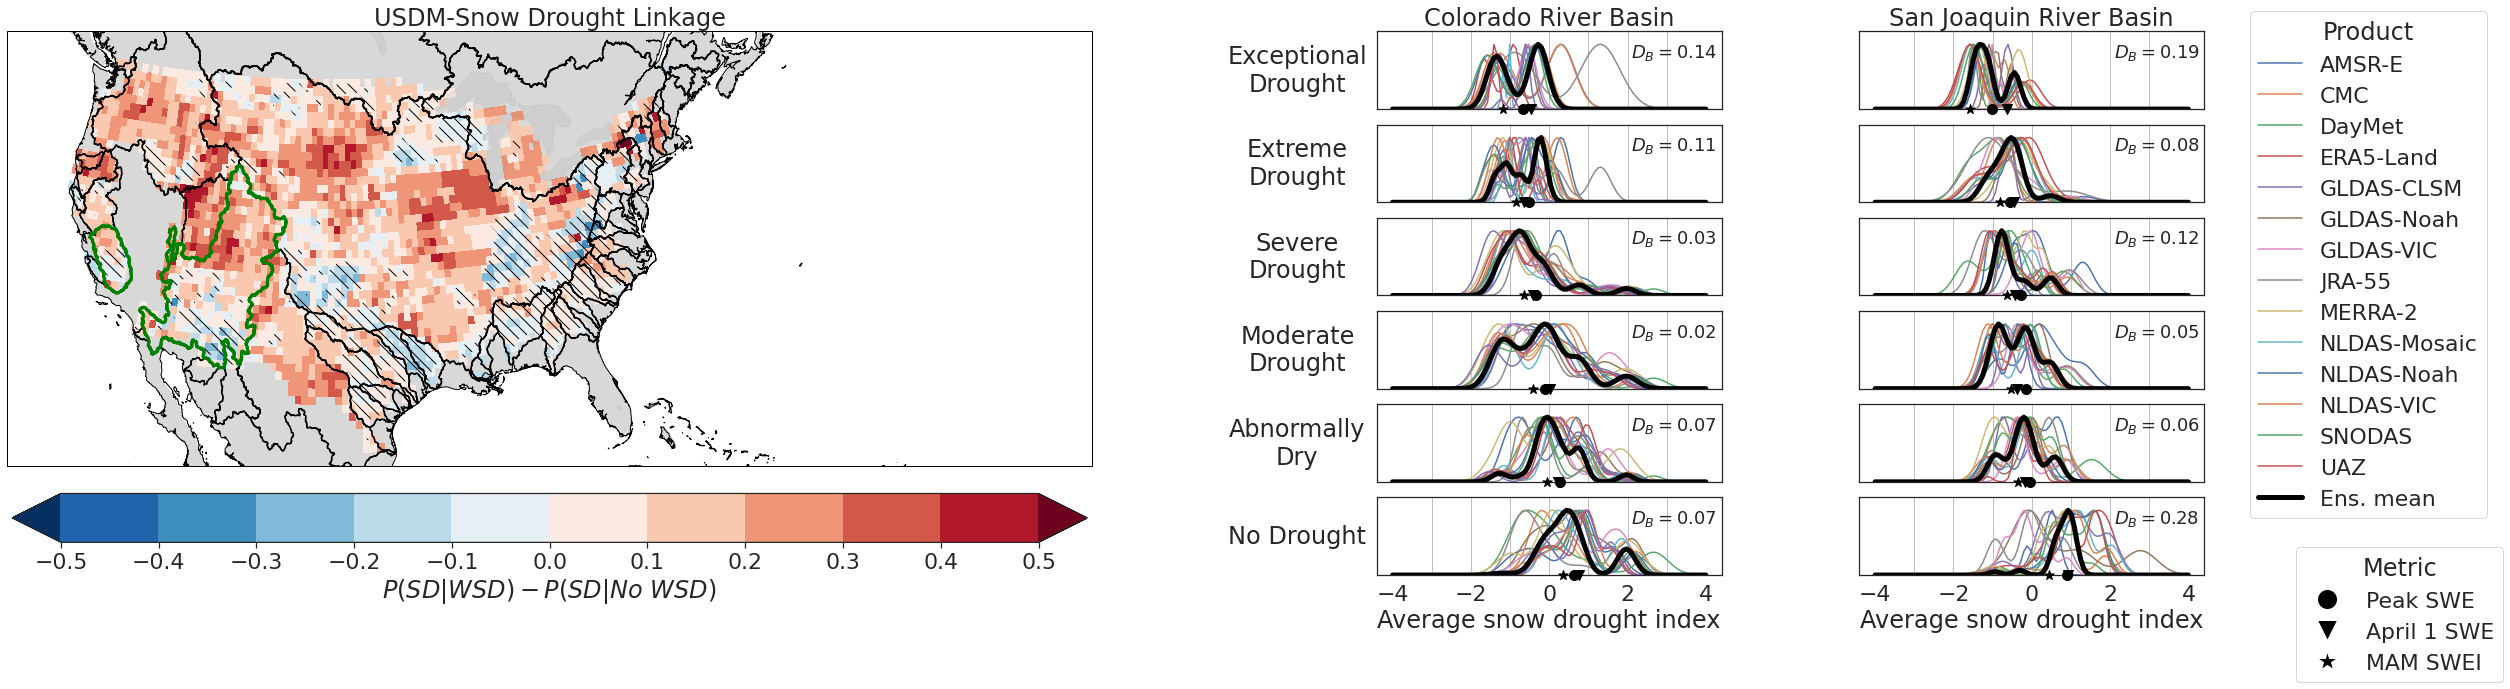

In [28]:
sns.set(style="white",font_scale=2)
fig = plt.figure(figsize=(42,10))
gs = gridspec.GridSpec(ncols=3,nrows=6,width_ratios=[1,0.25,0.25],figure=fig)

#################
### Figure 3a ###
#################

# colormap for difference in conditional probabilities
diff_cmap = plt.cm.get_cmap("RdBu_r")
diff_colors = [diff_cmap(i) for i in np.linspace(0.1,0.9,10)]
diff_cmap = mpl.colors.ListedColormap(diff_colors,name="diff")
diff_cmap.set_under(plt.cm.get_cmap("RdBu_r")(0))
diff_cmap.set_over(plt.cm.get_cmap("RdBu_r")(0.99))
diff_norm = plt.Normalize(vmin=-0.5,vmax=0.5)
         

ax0 = plt.subplot(gs[:6,0], projection=ccrs.AlbersEqualArea(central_latitude=40,central_longitude=-102))
da = (p_sd_wsd-p_sd_wsd_c) # difference in conditional probabilities
da.plot(ax=ax0, transform=ccrs.PlateCarree(), cmap=diff_cmap, norm=diff_norm, add_colorbar=False)
asp = ax0.get_aspect() # preserve aspect ratio b/c plotting basin boundaries distorts
ci_overlap["snow_drought"].plot.contourf(ax=ax0,transform=ccrs.PlateCarree(), colors="none",levels=[0,0.99,2],hatches=[None,"\\\\"],add_colorbar=False) # hatch where CIs overlap

# plot basin boundaries on map
us_basins = np.unique(basin_swe_ensemble["basin"].where(~xr.ufuncs.isnan(basin_swe_ensemble["drought_class"].max("time"))))
us_basins = us_basins[~np.isnan(us_basins)]
grdc_basins.loc[us_basins].geometry.boundary.plot(ax=ax0,transform=ccrs.PlateCarree(),color="black")
grdc_basins[grdc_basins.RIVER_BASI.isin(["COLORADO (also COLORADO RIVER)","SAN JOAQUIN"])].geometry.boundary.plot(ax=ax0,transform=ccrs.PlateCarree(),color="green",lw=3) # highlight UC and SJ

ax0.set_aspect(asp)
ax0.set_extent([-125,-45,25,41], ccrs.PlateCarree())
ax0.coastlines('10m')
ax0.add_feature(cartopy.feature.LAND, facecolor="grey",alpha=0.3)
ax0.add_feature(cartopy.feature.OCEAN,facecolor="white")
ax0.add_feature(cartopy.feature.LAKES,alpha=0.1,facecolor="grey")
ax0.title.set_text("USDM-Snow Drought Linkage")

# add colorbar
sm = plt.cm.ScalarMappable(cmap=diff_cmap,norm=diff_norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=[ax0],pad=0.05, orientation="horizontal",ticks=[-0.1*i for i in np.arange(-5,6)], extend="both",use_gridspec=True,shrink=0.78)
cbar.ax.set_xlabel(r"$P(SD|WSD) - P(SD|No\ WSD)$")

#################
### Figure 3b ###
#################
X_space = np.linspace(-4,4,100) # generate X values for estimating PDF

drought_classes = {-1:"No Drought",0:"Abnormally\nDry",1:"Moderate\nDrought",2:"Severe\nDrought",3:"Extreme\nDrought",4:"Exceptional\nDrought"}
for i in range(-1,5):
    
    # UPPER COLORADO RIVER BASIN
    ax = plt.subplot(gs[4-i,1])

    co_ens_mean = co_df.groupby(["drought_class","time","lat",'lon']).agg({"all_metrics":"mean"}).loc[i] # select drought class
    co_ens_mean_kde = gaussian_kde(co_ens_mean["all_metrics"].values,bw_method="scott") # estimate kernel density for ensemble mean
    bd = []
    for prod in co_df["product"].unique(): # for each product...
        X = co_df.loc[(co_df["drought_class"]==i)&(co_df["product"]==prod),"all_metrics"].values
        kde = gaussian_kde(X,bw_method="scott") # ...estimate kernel density
        bd.append(bhattacharyya_distance(kde.pdf(X_space),co_ens_mean_kde.pdf(X_space))) #...and calculate Bhattacharyya distance from every product to ensemble mean
        ax.plot(X_space,kde.pdf(X_space)/kde.pdf(X_space).max(),label=prod) # ...and plot normalized PDF

    ax.plot(X_space,co_ens_mean_kde.pdf(X_space)/co_ens_mean_kde.pdf(X_space).max(),color="black",lw=5,label="Ens. mean") # plot ensemble mean PDF
    ax.text(2.1,0.8,r"$D_B={0}$".format(np.round(np.median(bd),2)),fontsize=18) # add text indicating median Bhattacharyya distance

    ax.set_ylim(0,1.2)
    ax.vlines(np.arange(-3,4,1),ymin=0,ymax=1.2,color="grey",lw=0.5)
    ax.set_yticklabels([])
    ax.set_ylabel(drought_classes[i],rotation=0,labelpad=70,va="center")
    
    # add symbols showing ensemble mean for each metric along x-axis
    ax.scatter(co_class_means.loc[i]["peak_swe_anom"],0,marker="o",s=100,color="black",zorder=20,clip_on=False)
    ax.scatter(co_class_means.loc[i]["apr1_swe_anom"],0,marker="v",s=100,color="black",zorder=20,clip_on=False)
    ax.scatter(co_class_means.loc[i]["swei"],0,marker="*",s=100,color="black",zorder=20,clip_on=False)

    # SAN JOAQUIN RIVER BASIN
    ax2 = plt.subplot(gs[4-i,2])
    bd = []
    sj_ens_mean = sj_df.groupby(["drought_class","time","lat",'lon']).agg({"all_metrics":"mean"}).loc[i] # select drought class
    sj_ens_mean_kde = gaussian_kde(sj_ens_mean["all_metrics"].values,bw_method="scott") # estimate kernel density for ensemble mean

    for prod in sj_df["product"].unique(): # for each product...
        X = sj_df.loc[(sj_df["drought_class"]==i)&(sj_df["product"]==prod),"all_metrics"].values
        kde = gaussian_kde(X,bw_method="scott") # ...estimate kernel density
        bd.append(bhattacharyya_distance(kde.pdf(X_space),sj_ens_mean_kde.pdf(X_space))) #...and calculate Bhattacharyya distance from every product to ensemble mean
        ax2.plot(X_space,kde.pdf(X_space)/kde.pdf(X_space).max(),label=prod) # ...and plot normalized PDF
        
    ax2.plot(X_space,sj_ens_mean_kde.pdf(X_space)/sj_ens_mean_kde.pdf(X_space).max(),color="black",lw=5,label="Ens. mean") # plot ensemble mean PDF
    bd = [d for d in bd if not np.isnan(d)]
    ax2.text(2.1,0.8,r"$D_B={0}$".format(np.round(np.median(bd),2)),fontsize=18) # add text indicating median Bhattacharyya distance
    
    ax2.set_ylim(0,1.2)
    ax2.vlines(np.arange(-3,4,1),ymin=0,ymax=1.2,color="grey",lw=0.5)
    ax2.set_yticklabels([])
    
    # add symbols showing ensemble mean for each metric along x-axis
    ax2.scatter(sj_class_means.loc[i]["peak_swe_anom"],0,marker="o",s=100,color="black",zorder=20,clip_on=False)
    ax2.scatter(sj_class_means.loc[i]["apr1_swe_anom"],0,marker="v",s=100,color="black",zorder=20,clip_on=False)
    ax2.scatter(sj_class_means.loc[i]["swei"],0,marker="*",s=100,color="black",zorder=20,clip_on=False)

    if i != -1:
        ax.set_xticklabels([])
        ax2.set_xticklabels([])
    if i == 4:
        ax.title.set_text("Colorado River Basin")
        ax2.title.set_text("San Joaquin River Basin")
    if i == -1:
        ax.set_xlabel("Average snow drought index")
        ax2.set_xlabel("Average snow drought index")

# legend for metrics
leg_markers = list(ax2.get_lines())
leg2_markers = [Line2D([0],[0],color="w",marker="o",markersize=20,markerfacecolor="black",label="Peak SWE"),
                Line2D([0],[0],color="w",marker="v",markersize=20,markerfacecolor="black",label="April 1 SWE"),
                Line2D([0],[0],color="w",marker="*",markersize=20,markerfacecolor="black",label="MAM SWEI"),
                ]

# legend for products 
leg2 = plt.legend(handles=leg2_markers,bbox_to_anchor=(1.9,-5.5),title="Metric")
plt.legend(handles=leg_markers,bbox_to_anchor=(1.1,1.4),title="Product")
plt.gca().add_artist(leg2)

# difficult to get legends to line up, so fixed in Illustrator

plt.savefig(os.path.join(fig_dir,"fig3_main.png"),bbox_inches="tight",pad_inches=0.3)

In [ ]:
#